In [1]:
# IMPORTS

#---------------------------------------
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import copy # To copy multidimensional arrays
import time

In [2]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput is strictly a matrix of shape (N, 3), where N is the number of points to convert
# Be careful when N = 1 (shapen (3,)): you can use np.expand_dims(array, axis=0)
# or add manually the dimension
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[:, 0]
    theta = spherical_coordinates[:, 1]
    phi = spherical_coordinates[:, 2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    #
    # Return the result with the same shape of the input
    return np.stack([x, y, z], axis=1)

In [3]:
# PDF SAMPLING AND PLOTTING FUNCTIONS

#---------------------------------------------------------
# Compute a given PDF
#
# pdf: must be a callable that accepts x_grid as first positional parameter
# x_grid: the values over which the pdf has to be evaluated
# norm: whether to normalize numerically the PDF or not
# additional parameters are passed to pdf() through kwargs
def pdf_compute(pdf, x_grid, norm=False, **kwargs):
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapz(y_pdf, x_grid)
        y_pdf = y_pdf / norm
    
    return y_pdf

# Compute numerically the CDF of a given PDF along the x_grid
# The CDF is computed using the np.trapz() method
# Be aware of the limits of of np.trapz()
#
# parameters: see pdf_compute()
# norm: whether to normalize numerically the PDF or not
#       before computing the CDF
def cdf_compute_num(pdf, x_grid, norm=False, **kwargs):
    # Compute the pdf at each grid point
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapz(y_pdf, x_grid)
        y_pdf = y_pdf / norm

    # Compute the CDF by taking the cumulative integral on the grid points
    # array[:n] gives the first n terms of the array
    return np.array([np.trapz(y_pdf[:i+1], x_grid[:i+1]) for i in range(len(x_grid))])

# Compute a given PPF
#
# ppf: must be a callable that accepts P_grid as first positional parameter
# P_grid: the values over which the ppf has to be evaluated
#         They should be uniformly distributed random numbers between 0 and 1
# There is no norm parameter here because I hope that if you are lucky enough to have the CDF
# then it doens't need any adjustement (in reality I have no idea how to treat it at the present time,
# but this is a PDF oriented notebook afterall)
def ppf_compute(ppf, P_grid, **kwargs):
    return ppf(P_grid, **kwargs)

# A plotting utility to visualize a given PDF
#
# Same parameters as above plus the styling ones
#
# Returns the computed PDF to make the plot
def pdf_plotter(pdf, x_grid, norm=False,
                figsize=(12, 6), x_scale='linear', y_scale='linear',
                color=None,
                **kwargs):
    # Compute the PDF
    y_grid = pdf_compute(pdf, x_grid, norm=norm, **kwargs)

    # Plot the PDF
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(pdf.__name__)

    ax.plot(x_grid, y_grid, color=color)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    plt.show()

    # Return the computed PDF
    return y_grid

# A function that samples from a given PDF by performing
# a REJECTION SAMPLING technique
#
# pdf: the PDF from which to sample
# x_min, x_max, y_min, y_max: boundary of the box in which the rejection sampling is performed.
#                             the box should enclose completely the given pdf on the y axis.
#                             Choose a reasonable extension on the x axis to make a good sampling.
#                             BE AWARE OF WHAT YOU ARE SAMPLING!!
# size: the number of points to be sampled
# verbose: whether to print or not some diagnostic during the execution
# **kwargs: additional parameters to be passed to pdf()
#
# Returns the points sampled from the given PDF
def pdf_sampler(pdf,
                x_min, x_max, y_min, y_max,
                size=100, verbose=False, **kwargs):
    # Initialise the iteration counter
    iter_counter = 0

    # Initialise the array of sampled points and its lenght
    sampled_x = np.zeros(0)
    n_sample = len(sampled_x) # Number of sampled points
    
    # Sample until the desired number of points is reached
    while n_sample < size:
        # Generate (size - n_sample) uniformly distributed random numbers between 0 and 1
        x = np.random.uniform(x_min, x_max, size - n_sample)
        y = np.random.uniform(y_min, y_max, size - n_sample)

        # Get the PDF value for each of the x points
        # pdf_computed() here is not used to prevent an accidental parsing
        # of the norm parameter. Since 'x' can be very small in size normalizing is dangerous
        y_bound = pdf(x, **kwargs)

        # Append to the result array every x such that its y is smalle than its PDF
        # The '=' sign is necessary to account for limiting cases of constant pdf() functions
        sampled_x = np.append(sampled_x, x[y<=y_bound])

        # Compute the sampling efficiency of the performed iteration
        # i.e. how many point have been accepted out of the total generated (in the last iteration)
        samp_eff = 100 * len(x[y<=y_bound]) / (size - n_sample)

        # Update the number of sampled points and the iteration counter
        n_sample = len(sampled_x)
        iter_counter +=1

        # Print the diagnostic if required
        if verbose:
            # Build a diagnostic string
            diagnostic_str = ("Iteration {0}\n\n".format(iter_counter) +
                              "Sampling efficiency: {0} %\n".format(np.format_float_positional(samp_eff, 3)) +
                              "Sampled points: {0}\n".format(len(x[y<=y_bound])) +
                              "Progress: {0} out of {1}\n\n".format(n_sample, size))
            print(diagnostic_str)

    # Return the sampled points
    return sampled_x

# A plotting utility to visualize the sampled PDF
#
# pdf, x_grid: see pdf_plotter()
# sampled_x: the points sampled from the PDF (likely by pdf_sampler())
# norm: whether to normalize numerically the PDF or not
# quantiles: quantile lines to overplot on the samples distribution
# q_color: color of the quantiles
# q_styles: linestyle for each quantile
# styling parameters. 
# x_scale, y_scale: axis scales for both the plots: 0: PDF
#                                                   1: Samples distribution
# **kwargs: additional parameters to be passed to pdf()
def sampler_diagnostic_plot(pdf, x_grid, sampled_x, norm=False,
                            quantiles=[0.16, 0.5, 0.84], q_color='black', q_styles=[':', '-.', '--'],
                            figsize=(18, 6), bins='auto', histtype='step', color=None,
                            x_scale=['linear', 'linear'], y_scale=['linear', 'linear'],
                            **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    # Plot the PDF
    ax[0].set_title(pdf.__name__)

    ax[0].plot(x_grid, pdf_compute(pdf, x_grid, norm=norm, **kwargs), color=color)

    ax[0].set_xscale(x_scale[0])
    ax[0].set_yscale(y_scale[0])

    # Plot the sampled PDF
    ax[1].set_title("Sampled " + pdf.__name__)
    
    ax[1].hist(sampled_x, bins=bins, density=True, histtype=histtype, color=color)

    # Compute and plot also some quantiles
    x_quantiles = np.quantile(sampled_x, quantiles)
    for q in range(len(quantiles)):
        ax[1].axvline(x_quantiles[q], color=q_color, linestyle=q_styles[q])

    ax[1].set_xscale(x_scale[1])
    ax[1].set_yscale(y_scale[1])

# A support function that genarates and returns support variables
#
# pdf: the PDF to use
# x_min, x_max: limits of the x_grid to be generated
# grid_n_points: number of points in the grid
# **kwargs: additional parameters to be passed to pdf()
#
# Returns a list: index 0: pdf
#                 index 1: [x_grid, y_grid]
#                 index 2: [x_min, y_min]
#                 index 3: [x_max, y_max]
#                 index 4: kwargs
def pdf_initialiser(pdf, x_min, x_max, grid_n_points=1000, **kwargs):
    x_grid = np.linspace(x_min, x_max, grid_n_points)
    y_grid = pdf(x_grid, **kwargs)

    y_min = np.min(y_grid)
    y_max = np.max(y_grid)

    return [pdf, [x_grid, y_grid], [x_min, y_min], [x_max, y_max], kwargs]

# Generates points in a sphere based on the given PDFs and their bounds
# pdf: the PDF to use
# bounds: list of 2 numbers: [min, max]
# size: the size of the sampling
# size_init: the size for the initialiser x_grid
#            Not important, here just for consistency
# pdf_args: dictionaries for additional arguments for the pdf() functions
#           Use dict(arg1=value1, arg2=value2, ...) to build them
def generate_spherical_points(pdf_r, r_bounds,
                              pdf_theta, theta_bounds,
                              pdf_phi, phi_bounds,
                              size=1, size_init=1000,
                              pdf_r_args={}, pdf_theta_args={}, pdf_phi_args={}):
    
    # Make ordered lists of the parameters
    pdf_list = [pdf_r, pdf_theta, pdf_phi]
    pdf_args_list = [pdf_r_args, pdf_theta_args, pdf_phi_args]
    bounds_list = [r_bounds, theta_bounds, phi_bounds]

    # Initialise all the PDF variables
    init_list = [pdf_initialiser(pdf_list[i], bounds_list[i][0], bounds_list[i][1],
                                 size_init, **pdf_args_list[i])
                                 for i in range(3)]

    # Sample from each PDF
    samples_list = [pdf_sampler(init_list[i][0],
                                init_list[i][2][0], init_list[i][3][0], init_list[i][2][1], init_list[i][3][1],
                                size=size, **init_list[i][4])
                                for i in range(3)]
    
    # Return the result as a (size, 3) shaped matrix
    return np.stack([samples_list[0], samples_list[1], samples_list[2]], axis=1)

In [4]:
# DISTRIBUTION DEFINITIONS

#-------------------------------------------------
# Define there the proper distributions to be used for each variable

def pdf_q(q):
    return (q ** 2) * (1 - q ** 2) ** (7 / 2)

# Conversion from (r, b, q) to v
def v(r, b, M, q):
    return (q * np.sqrt(2 * M)) * ((r ** 2) + (b ** 2)) ** (-1 / 4)

# Note that since the rejection sampling requires to define the boundary
# of the sampling, it gives more control over the maximum possible radius
# In that case use the PDF and the pdf_sampler()
def pdf_r(r, b):
    return  (3 * r ** 2) / (b ** 3) * (1 + (r / b) ** 2) ** (-5 / 2)

# Using the PPF instead, is pretty because it's anlytical, but the maximum radius sampled
# is only limited by how lucky (or unlucky) is the uniform sampling between 0 and 1
# Obviously one can manually discard high values by setting some threshold, but I don't like it
def ppf_r(P, b):
    return b * ((P ** (-2 / 3)) - 1) ** (-1 / 2)

def pdf_theta(theta):
    return np.sin(theta) / 2

def ppf_theta(P):
    return np.arccos(1 - 2 * P)

def pdf_phi(phi):
    return stats.uniform.pdf(phi, 0, 2 * np.pi)

def ppf_phi(P):
    return stats.uniform.ppf(P, 0, 2 * np.pi)

In [5]:
# PHYSICS FUNCTIONS

#-------------------------------------------------

# PLUMMER SPHERE
#-------------------------------------------------
# Total energy of the plummer sphere
# G = 1
def total_energy(b, M):
    return (-3 * np.pi / 64) * (M ** 2) / b

# Circular velocities at given radius
def v_circ(r, b, M):
    return np.sqrt(M * (r ** 2) * ((r ** 2) + (b ** 2)) ** (-3 / 2))

# Example of numerically computing the inverse CDF (PPF)

Fitted PPF domain: [0. 1.]


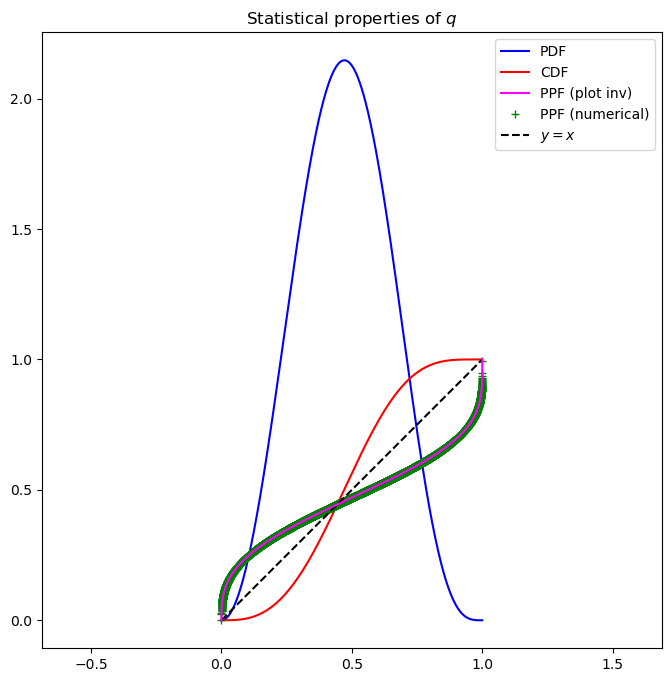

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title(r'Statistical properties of $q$')

# Make a grid
n_grid = 10000
x_grid = np.linspace(0, 1, n_grid)

# Computed the PDF
y_grid = pdf_compute(pdf_q, x_grid, norm=True)

# Computed the CDF
c_integral = cdf_compute_num(pdf_q, x_grid, norm=True)

# Fit a Legendre polynomial to the inverse CDF (the PPF)
# You just need to do the inversion: x_grid -> c_integral and c_integral -> x_grid
# In practice just put y in place of x and viceversa
ppf_fit = np.polynomial.Legendre.fit(c_integral, x_grid, deg=1000)
print("Fitted PPF domain:", ppf_fit.domain) # Print the domain of the fitted PPF
ppf_values = ppf_fit.linspace(n_grid) # Evaluate the fitted PPF on its domain

# Plot the PDF, CDF, PPF and numerical computed PPF
ax.plot(x_grid, y_grid, color='blue', label='PDF', zorder=0)

# Also the CDF is computed numerically actually, but that's not the focus
ax.plot(x_grid, c_integral, color='red', label='CDF', zorder=1)

# PPF by inverting the CDF coordinates
ax.plot(c_integral, x_grid, color='magenta', label='PPF (plot inv)', zorder=3)

# Numerically fitted PPF
ax.plot(ppf_values[0], ppf_values[1], marker='+', linestyle='', c='green', label='PPF (numerical)', zorder=2)

# Plot y=x line
ax.plot(x_grid, x_grid, color='black', linestyle='--', label=r'$y=x$')

ax.set_aspect('equal', 'datalim')
ax.legend()

plt.show()

Note that the fitted PPF using Legendre polynomials might not be precise near the edges of the domain. Probably because this PPF is not $L_2$ on $[0,1]$.

In our case we expect $\text{PPF}(0)=0$ and $\text{PPF}(1)=1$

In [7]:
# Compute the numerical PPF in 0 and 1
print(ppf_compute(ppf_fit, np.array([0, 1])))

[0.00186576 0.99226896]


However the precision increases very rapidily when leaving the domain limits.

# Define the parameters of the distribution

In [8]:
# PARAMETERS OF THE DISTRIBUTION

#----------------------------------------------
N = 10000 # Number of particles
b = 10 # Scale radius of the sphere
M = 1 # Total mass of the distribution
t0 = 0 # Initial time. To be writed in the input_file

# Sampling bounds for each variable
r_bounds = [0, 10 * b]
theta_bounds = [0, np.pi]
phi_bounds = [0, 2 * np.pi]
q_bounds = [0, 1]

E = total_energy(b, M) # Total energy of the system
m = M / N # Mass of each particle

# Conversion factors to apply to the sampled lenghts if fixing b=1
lenght_conversion_factor_b1 = (3 * np.pi / 64) * (M ** 2) / np.abs(E)

# Conversion factors to apply to the sampled velocities if fixing b=1 and M=1
velocity_conversion_b1_m1 = np.sqrt(64 / (3 * np.pi)) * np.sqrt(np.abs(E) / M)

# Conversion factors to apply to the sampled velocities if fixing b=1
velocity_conversion_m1 = np.sqrt(M)

print(lenght_conversion_factor_b1, b, sep='   ')
print(velocity_conversion_b1_m1, np.sqrt(M / b), sep='   ')
print(velocity_conversion_m1)

10.0   10
0.31622776601683794   0.31622776601683794
1.0


# Check that everything works

In [9]:
# Size of the sampling for the plots
size = 100000

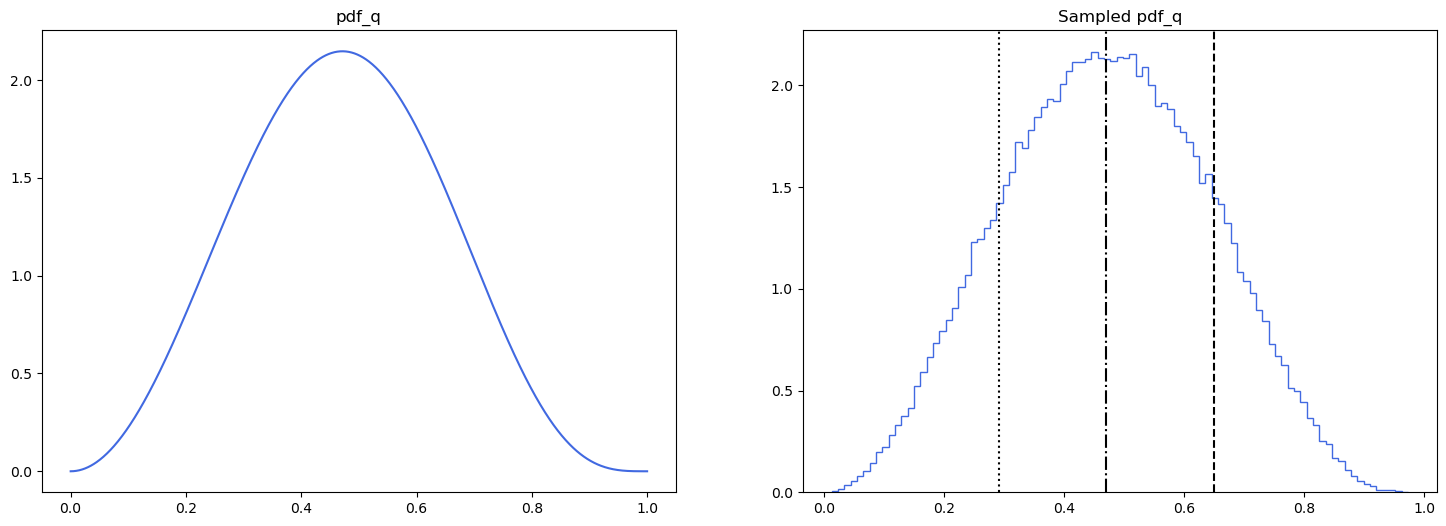

In [10]:
q_init = pdf_initialiser(pdf_q, q_bounds[0], q_bounds[1])

sampled_q = pdf_sampler(q_init[0],
                        q_init[2][0], q_init[3][0], q_init[2][1], q_init[3][1],
                        size=size, **q_init[4])
sampler_diagnostic_plot(q_init[0], q_init[1][0], sampled_x=sampled_q, norm=True, **q_init[4],
                        color='royalblue')

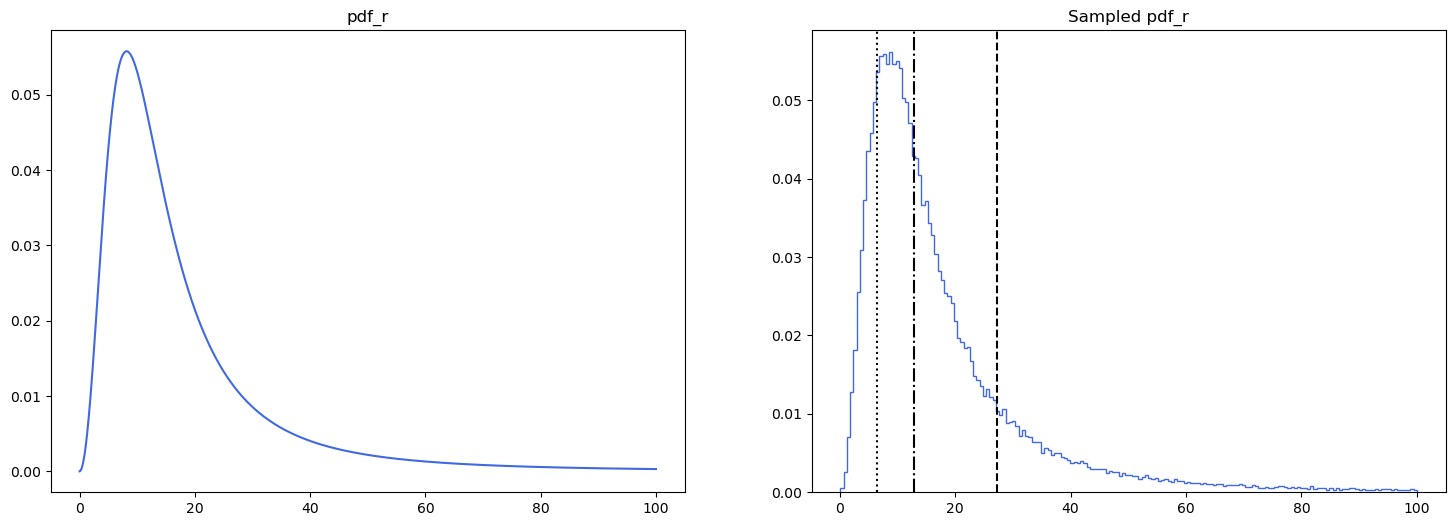

In [11]:
r_init = pdf_initialiser(pdf_r, r_bounds[0], r_bounds[1], b=b)

sampled_r = pdf_sampler(r_init[0],
                        r_init[2][0], r_init[3][0], r_init[2][1], r_init[3][1],
                        size=size, **r_init[4])
sampler_diagnostic_plot(r_init[0], r_init[1][0], sampled_x=sampled_r, **r_init[4],
                        color='royalblue')

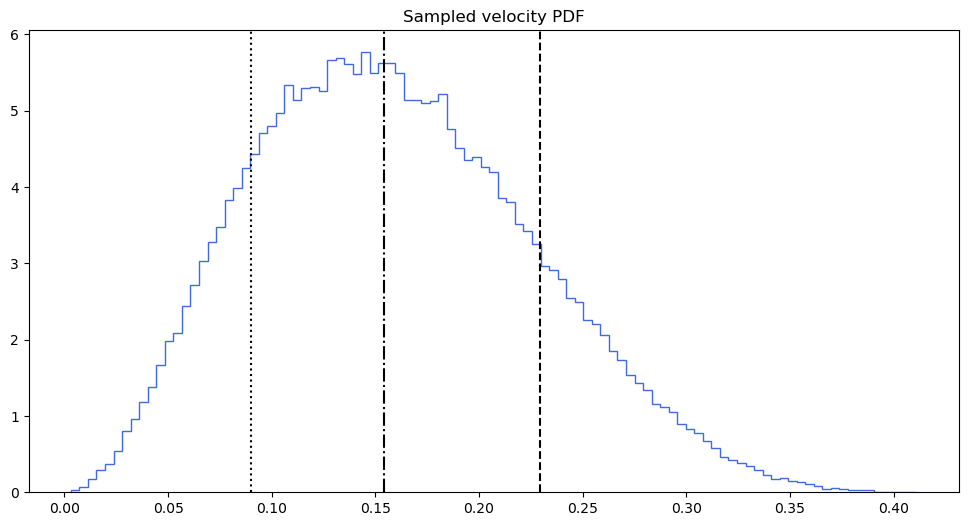

In [12]:
# Compute the velocities from the sampled q and r
sampled_v = v(sampled_r, b, M, sampled_q)

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Sampled velocity PDF")

ax.hist(sampled_v, bins='auto', density=True, histtype='step', color='royalblue')

# Compute and plot also some quantiles
sampled_v_quantiles = np.quantile(sampled_v, [0.16, 0.5, 0.84])
sampled_v_quantiles_styles = [':', '-.', '--'] # Quantile styles
for q in range(len(sampled_v_quantiles)):
    ax.axvline(sampled_v_quantiles[q], color='black', linestyle=sampled_v_quantiles_styles[q])

plt.show()

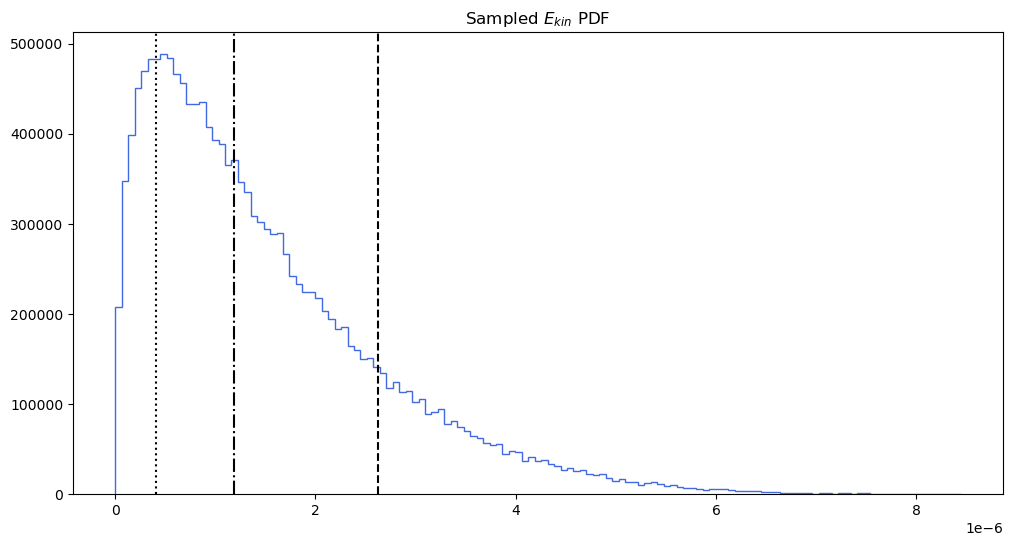

In [13]:
# Plot the distribution of the velocities squared
sampled_E_kin = (m * sampled_v ** 2) / 2

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title(r"Sampled $E_{kin}$ PDF")

ax.hist(sampled_E_kin, bins='auto', density=True, histtype='step', color='royalblue')

# Compute and plot also some quantiles
sampled_E_kin_quantiles = np.quantile(sampled_E_kin, [0.16, 0.5, 0.84])
sampled_E_kin_quantiles_styles = [':', '-.', '--']
for q in range(len(sampled_E_kin_quantiles)):
    ax.axvline(sampled_E_kin_quantiles[q], color='black', linestyle=sampled_E_kin_quantiles_styles[q])

plt.show()

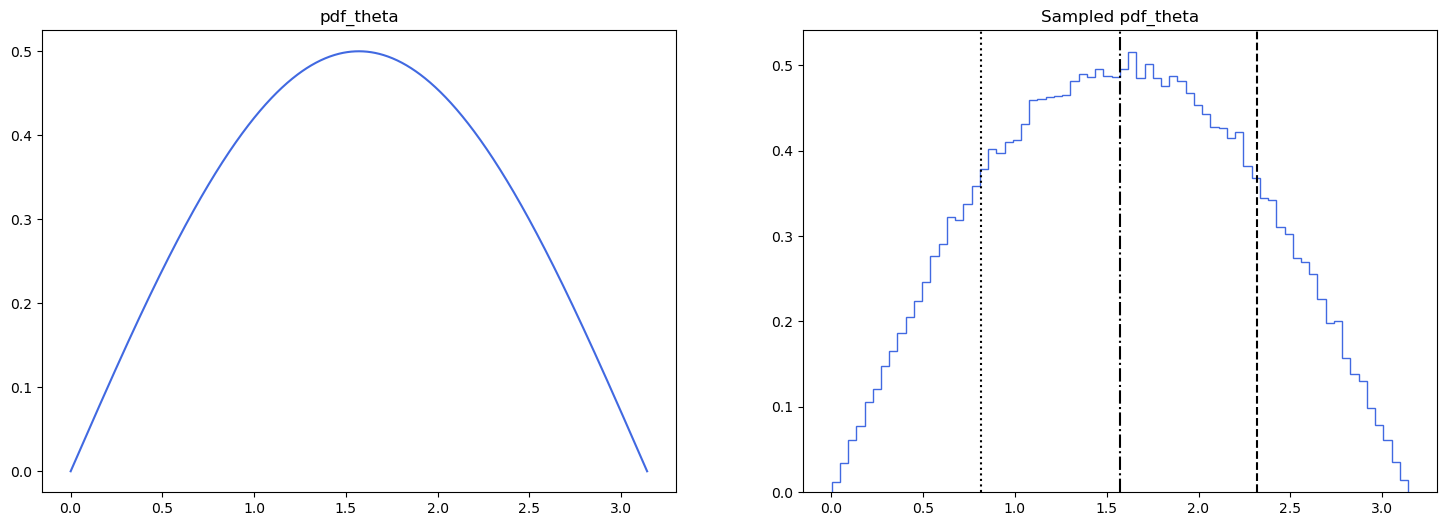

In [14]:
theta_init = pdf_initialiser(pdf_theta, theta_bounds[0], theta_bounds[1])

sampled_theta = pdf_sampler(theta_init[0],
                            theta_init[2][0], theta_init[3][0], theta_init[2][1], theta_init[3][1],
                            size=size, **theta_init[4])
sampler_diagnostic_plot(theta_init[0], theta_init[1][0], sampled_x=sampled_theta, **theta_init[4],
                        color='royalblue')

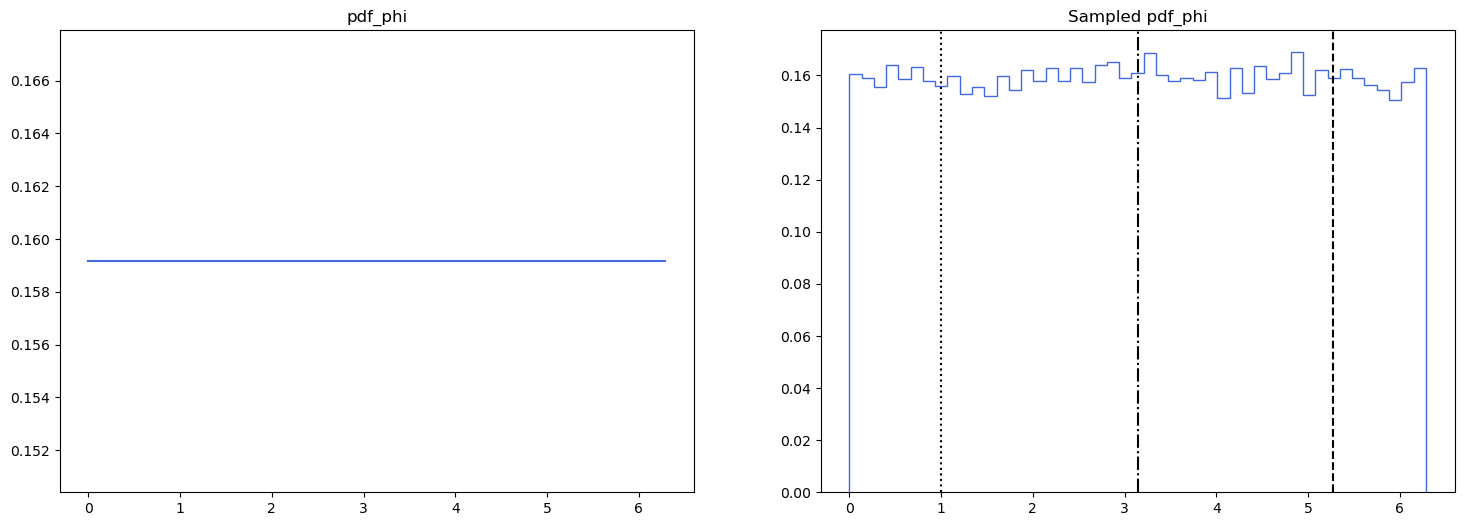

In [15]:
phi_init = pdf_initialiser(pdf_phi, phi_bounds[0], phi_bounds[1])

sampled_phi = pdf_sampler(phi_init[0],
                          phi_init[2][0], phi_init[3][0], phi_init[2][1], phi_init[3][1],
                          size=size, **phi_init[4])
sampler_diagnostic_plot(phi_init[0], phi_init[1][0], sampled_x=sampled_phi, **phi_init[4],
                        color='royalblue')

# Numerical proof of conversion factors

I want to check that the conversion factors properly transforms the sampled data.

In [16]:
# PPF FIT

#--------------------------------------------------
# Wheter to fit or not the PPF of q
execute_fit = False

#--------------------------------------------------
if execute_fit:
    # Sample some values of q
    # Define the q_grid
    q_grid = np.linspace(q_bounds[0], q_bounds[1], size)

    # Computed the CDF of q. Be sure it is normalised
    q_cdf = cdf_compute_num(pdf_q, q_grid, norm=True)

    # Fit a Legendre polynomial to the inverse CDF (the PPF)
    # You just need to do the inversion: q_grid -> q_cdf and q_cdf -> q_grid
    ppf_q_fit = np.polynomial.Legendre.fit(q_cdf, q_grid, deg=1000)

    # Print the domain of the fitted polynomial
    print("Fitted PPF domain:", ppf_q_fit.domain)

Actually I could have used the sampled $q$ from above, but experimenting with Legendre to find the PPF seemed fun.

In [17]:
if execute_fit:
    # Plot the CDF and the PPF to check that everithing is ok
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # Compute the values of the Fitted PPF
    ppf_q_fit_vals = ppf_q_fit.linspace(size)
    
    # Plot the CDF and the PDF
    ax.plot(q_grid, q_cdf, color='red', label='CDF')
    ax.plot(ppf_q_fit_vals[0], ppf_q_fit_vals[1], color='green', label='PPF (numerical)')

    # Plot y=x line
    ax.plot(q_grid, q_grid, color='black', linestyle='--', label=r'$y=x$')

    ax.set_aspect('equal', 'datalim')
    ax.legend()

    plt.show()

In [18]:
# Sample values of q by using its numerical computed PPF
# Be careful to restrict the sampling to the domain of the fitted polynomial
if execute_fit:
    samp_q = ppf_compute(ppf_q_fit, np.random.uniform(ppf_q_fit.domain[0], ppf_q_fit.domain[1], size))
else: # Otherwise pick the sampled q from above
    samp_q = sampled_q

## _Check the seeds!!_

In [19]:
seed = 20240505
# Sample values of the radius with the user decided b
# Note that I have to initialise the seed for each radius sampling at the same value
# Otherwise the sampled distributions would be surely different
# Check what happens at the distributions when sampling with different seeds
np.random.seed(seed)
samp_r = ppf_compute(ppf_r, np.random.uniform(0, 1, size), b=b)

# Sample values of the radius with b = 1
np.random.seed(seed)
samp_r_b1 = ppf_compute(ppf_r, np.random.uniform(0, 1, size), b=1)

# Get the sampled velocities in the two cases
samp_v = v(samp_r, b, M, samp_q)
samp_v_b1 = v(samp_r_b1, 1, 1, samp_q)

In [20]:
# Check the equality between samples before and after the conversion
equal_mask_before_conversion = samp_r == samp_r_b1
equal_mask_after_conversion = samp_r == samp_r_b1 * lenght_conversion_factor_b1

# Compute the success rate of the conversion
success_rate = 100 * np.sum(equal_mask_after_conversion) / size

# Build a diganostic string
diagnostic_str_radius = ("RADIUS\n\n"
                         "Size of sampling: {size}\n"
                         "Equal values before conversion: {n_equal_before}\n"
                         "Equal values after conversion: {n_equal_after}\n"
                         "Success rate: {success_rate} %\n\n").format(
                             size=size,
                             n_equal_before=np.sum(equal_mask_before_conversion),
                             n_equal_after=np.sum(equal_mask_after_conversion),
                             success_rate=np.format_float_positional(success_rate, 3))

# Repeat for the velocities
equal_mask_before_conversion = samp_v == samp_v_b1
equal_mask_after_conversion = samp_v == samp_v_b1 * velocity_conversion_b1_m1

success_rate = 100 * np.sum(equal_mask_after_conversion) / size

diagnostic_str_velocity = ("VELOCITY\n\n"
                           "Size of sampling: {size}\n"
                           "Equal values before conversion: {n_equal_before}\n"
                           "Equal values after conversion: {n_equal_after}\n"
                           "Success rate: {success_rate} %\n\n").format(
                               size=size,
                               n_equal_before=np.sum(equal_mask_before_conversion),
                               n_equal_after=np.sum(equal_mask_after_conversion),
                               success_rate=np.format_float_positional(success_rate, 3))

# Print the diagntostic strings
print(diagnostic_str_radius, diagnostic_str_velocity, sep='\n')

RADIUS

Size of sampling: 100000
Equal values before conversion: 0
Equal values after conversion: 100000
Success rate: 100. %


VELOCITY

Size of sampling: 100000
Equal values before conversion: 0
Equal values after conversion: 55730
Success rate: 55.73 %




In [21]:
# Make some plottig support variables

#---------------------------------------------
# Store the sampled quantities
sampled_qty = [[samp_r.copy(), samp_r_b1.copy()],
               [samp_v.copy(), samp_v_b1.copy()]]

# Compute and store the corrected sampled quantities
# Use deepcopy() to copy multidimensional lists
corrected_sampled_qty = copy.deepcopy(sampled_qty)
corrected_sampled_qty[0][1] *= lenght_conversion_factor_b1
corrected_sampled_qty[1][1] *= velocity_conversion_b1_m1

# Store the residuals
residuals = [corrected_sampled_qty[0][0] - corrected_sampled_qty[0][1],
             corrected_sampled_qty[1][0] - corrected_sampled_qty[1][1]]

# Make titles
titles = ['Radius', 'Velocity']

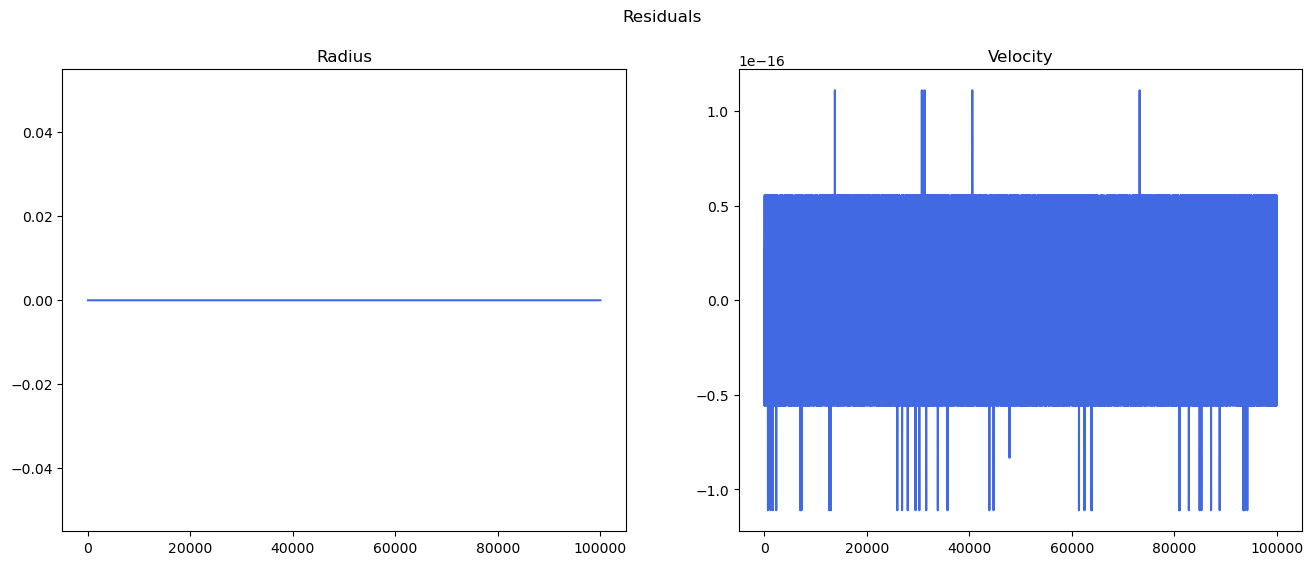

In [22]:
# Plot the residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Residuals")

for ax, i in zip(axes, range(len(axes))):
    ax.set_title(titles[i])
    ax.plot(range(len(residuals[i])), residuals[i], color='royalblue')

The bad success conversion rate for velocities is likely due to numerical errors.

Let's have a look at the distributions of the sampled velocities.

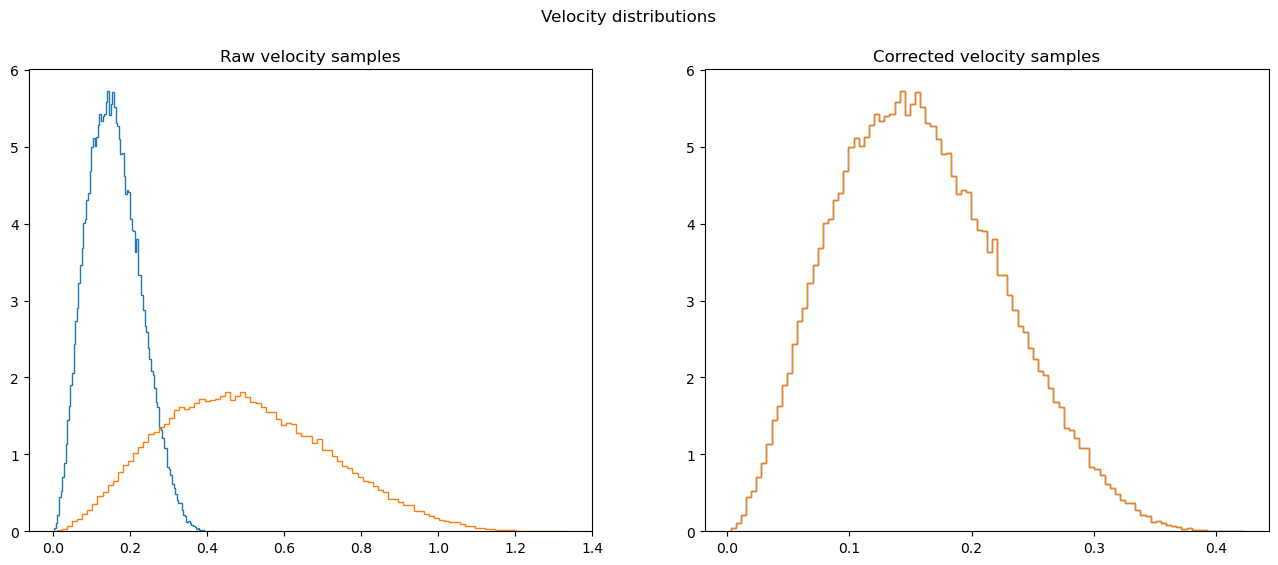

In [23]:
# Quick plot of the velocities distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Velocity distributions")

for j in range(2):
    axes[0].set_title("Raw velocity samples")
    axes[0].hist(sampled_qty[1][j], bins='auto', density=True, histtype='step')

    axes[1].set_title("Corrected velocity samples")
    axes[1].hist(corrected_sampled_qty[1][j], bins='auto', density=True, histtype='step')

# Generate the plummer distribution

## Generate the points

In [24]:
# Randomise the random seed since it has been fixed before
np.random.seed(int(time.time()))

In [25]:
# Generate points in spherical coordinates
spherical_positions = generate_spherical_points(pdf_r, r_bounds,
                                                pdf_theta, theta_bounds,
                                                pdf_phi, phi_bounds,
                                                size=N,
                                                pdf_r_args=dict(b=b))

spherical_velocities = generate_spherical_points(pdf_q, q_bounds,
                                                 pdf_theta, theta_bounds,
                                                 pdf_phi, phi_bounds,
                                                 size=N)

# Note that we sampled q for the radial component of the velocities
# Convert q to velocities
radial_velocities = v(spherical_positions[:, 0], b, M, spherical_velocities[:, 0])
spherical_velocities[:, 0] = radial_velocities

print(spherical_positions, spherical_velocities, sep='\n\n')

[[17.78117195  0.62478207  5.65825139]
 [15.86299011  1.66327605  4.67789982]
 [17.64705483  1.78144421  1.20693929]
 ...
 [14.22924386  1.7846631   0.22542064]
 [10.47087662  1.74677667  4.0837898 ]
 [ 4.8813345   1.04639982  4.01088853]]

[[0.14381544 2.05296184 1.78360661]
 [0.2022173  1.98898215 2.07792599]
 [0.1457121  0.58274999 5.05532632]
 ...
 [0.09351483 0.57192323 4.78272937]
 [0.1794799  2.70976825 4.80853792]
 [0.33314925 0.12809115 3.71640447]]


In [26]:
# Convert points in cartesian coordinates
cartesian_positions = spherical_to_cartesian(spherical_positions)
cartesian_velocities = spherical_to_cartesian(spherical_velocities)

print(cartesian_positions, cartesian_velocities, sep='\n\n')

[[  8.43488278  -6.08478913  14.42214164]
 [ -0.54465528 -15.78581106  -1.46491468]
 [  6.14143745  16.12718332  -3.68988459]
 ...
 [ 13.5532709    3.1080101   -3.02001687]
 [ -6.0619114   -8.33858303  -1.83317224]
 [ -2.72693076  -3.22768486   2.44403878]]

[[-0.02691196  0.12454502 -0.06668706]
 [-0.0897478   0.16153418 -0.08212111]
 [ 0.0269638  -0.07551929  0.12166267]
 ...
 [ 0.00355734 -0.05048976  0.07863303]
 [ 0.00721134 -0.07477049 -0.16300431]
 [-0.03571776 -0.02313719  0.33041994]]


# Relevant quantities

## Max radial velocity

In our case the maximum possible velocity is the escape velocity of the innermost possible particle. Since the absolute minimum value of the radius is zero, let's take the minimum sampled radius and compute its escape velocity (i.e. $q=1$).

## Max circular velocity
Evaluate the circular veloctiy of the outermost possible particle. This is user defined if the sampling have been done by rejection sampling (just take the right bound of the radii sampling box).

## Minimum time scale

Estimate the smaller time scale of the system as $r_{\min}/v_{\max}^{\text{esc}}$.

In [27]:
min_r = np.min(spherical_positions[:, 0]) # Minimum sampled radius
max_esc_v = v(min_r, b, M, q=1) # Maximum escape velocity relative to the minimum radius
max_sampled_v = np.max(spherical_velocities[:, 0]) # Maximum sampled (radial) velocity
max_circ_v = v_circ(r_bounds[1], b, M) # Circular velocity of the outermost possible particle

# Minimum time scale of the (sampled) system
min_time = min_r / max_esc_v

# Maximum circular period
max_circ_time = 2 * np.pi * r_bounds[1] / max_circ_v

# Dynamical time of the particle with the higher possible value
max_dyn_time = max_circ_time / 4

summary_str = ("RADIUS\n"
               "Minimum sampled radius: {min_r}\n\n"
               "ESCAPE VELOCITY\n"
               "Maximum escape velocity: {max_esc_v}\n"
               "Minimum time scale: {min_time}\n\n"
               "Maximum sampled velocity: {max_sampled_v}\n\n"
               "CIRCULAR VELOCITY\n"
               "Maximum circular velocity: {max_circ_v}\n"
               "Maximum circular period: {max_circ_time}\n"
               "Maximum dynamical time: {max_dyn_time}\n\n").format(
                   min_r=min_r,
                   max_esc_v=max_esc_v,
                   max_sampled_v=max_sampled_v,
                   min_time=np.format_float_scientific(min_time, 3),
                   max_circ_v=max_circ_v,
                   max_circ_time=max_circ_time,
                   max_dyn_time=np.format_float_scientific(max_dyn_time, 3))

print(summary_str)

RADIUS
Minimum sampled radius: 0.1905584517779335

ESCAPE VELOCITY
Maximum escape velocity: 0.44717300607590305
Minimum time scale: 4.261e-01

Maximum sampled velocity: 0.3933518173997908

CIRCULAR VELOCITY
Maximum circular velocity: 0.09925650290240803
Maximum circular period: 6330.250536186432
Maximum dynamical time: 1.583e+03




## Drifting velocity

If you want add a drifting velocity to the plummer sphere.

In [28]:
# Whether to add a drifting velocity or not or not
add_drifting = False

# Define the drifting velocity in cartesian components
v_drift = np.array([0.01, 0.01, 0.01])

if add_drifting:
    # Print velocities before adding drift
    print(cartesian_velocities, '\n')

    # Add drifting velocity
    for i in range(3):
        cartesian_velocities[:, i] += v_drift[i]

    # Print velocities after drift have been added
    print(cartesian_velocities)

## Plot the points

In [29]:
# Make swaped-axes variables for plots
pos_for_plot = np.swapaxes(cartesian_positions, 0, 1)
vel_for_plot = np.swapaxes(cartesian_velocities, 0, 1)

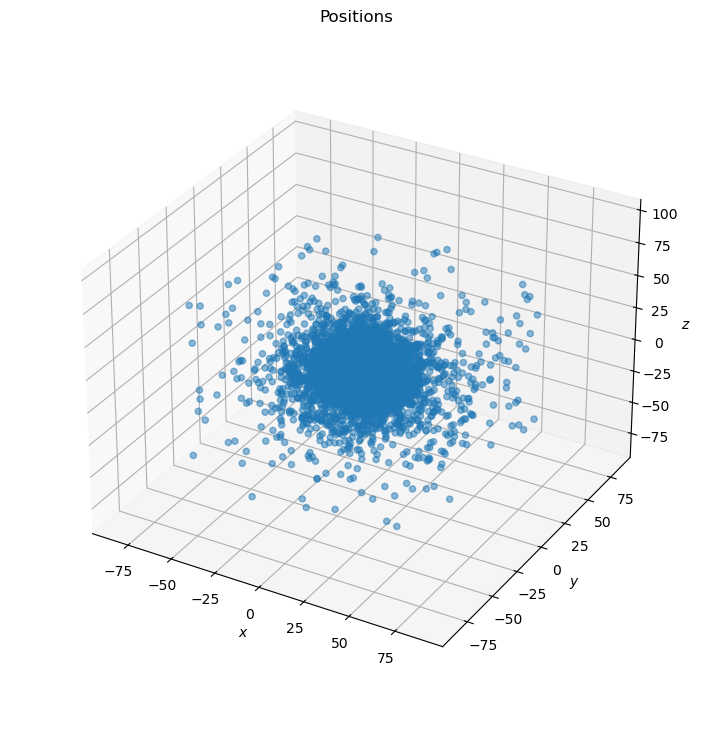

In [30]:
# Initialise a 3D plot
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

ax.set_title("Positions")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

ax.scatter(pos_for_plot[0], pos_for_plot[1], pos_for_plot[2], alpha=0.5)

plt.show()

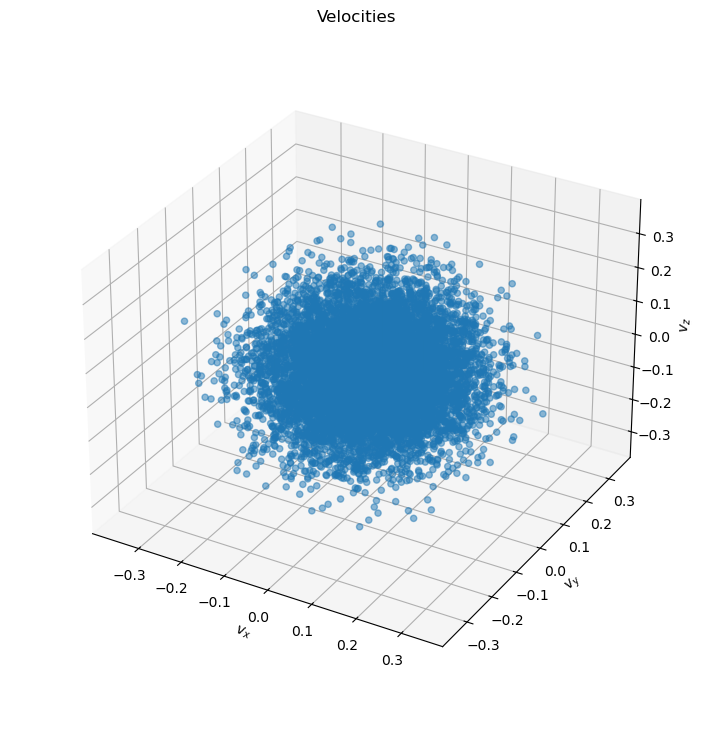

In [31]:
# Initialise a 3D plot
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

ax.set_title("Velocities")

ax.set_xlabel("$v_x$")
ax.set_ylabel("$v_y$")
ax.set_zlabel("$v_z$")

ax.scatter(vel_for_plot[0], vel_for_plot[1], vel_for_plot[2], alpha=0.5)

plt.show()

# Build the _treecode_ input file

In [32]:
# Variables to store the string lines to be put in the input file
masses = []
positions = []
velocities = []

# Fill the variables
for i in range(N):
    masses.append('\n' + str(m))
    positions.append('\n' + ' '.join(str(coord) for coord in cartesian_positions[i]))
    velocities.append('\n' + ' '.join(str(coord) for coord in cartesian_velocities[i]))

In [33]:
# Whether to make an input file or not
make_input = False

if make_input:
    # Create or overwrite the input file
    file_name = "input.txt"

    input_file = open(file_name, 'w')

    # Write a file in the proper format for the treecode program:
    #
    # N
    # n_dim
    # t_0
    # m_1
    # ..
    # m_N
    # x_1, y_1, z_1
    # ...
    # x_N, y_N, z_N
    # vx_1, vy_1, vz_1
    # ...
    # vx_N, vy_N, vz_N
    input_file.write(str(N))
    input_file.write('\n' + str(3)) # Number of dimensions
    input_file.write('\n' + str(t0))
    
    input_file.writelines(masses)
    input_file.writelines(positions)
    input_file.writelines(velocities)

    input_file.close()